### chapter 2

In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

- 뒷쪽의 2-4 예제 먼저..
- columns
    - price: 자동차 가격
    - maint: 자동차 유지 비용
    - dours: 자동차 문의 개수
    - persons: 수용 인원
    - lug_capacity: 수하물 용량
    - sefety: 안정성
    - output: 차상태

In [3]:
car_df = pd.read_csv('./chap02/car_evaluation.csv')
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         1728 non-null   object
 1   maint         1728 non-null   object
 2   doors         1728 non-null   object
 3   persons       1728 non-null   object
 4   lug_capacity  1728 non-null   object
 5   safety        1728 non-null   object
 6   output        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [4]:
car_df.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
car_df['doors'].value_counts()

doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64

In [6]:
car_df['persons'].value_counts()

persons
2       576
4       576
more    576
Name: count, dtype: int64

In [8]:
car_df.duplicated().sum()

0

In [23]:
colname = car_df.columns.to_list()
type(colname), colname

(list,
 ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety', 'output'])

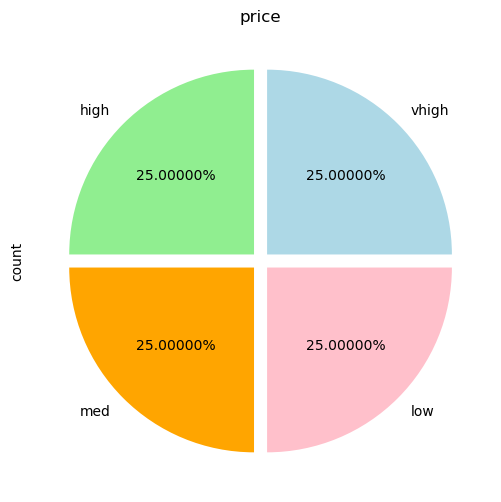

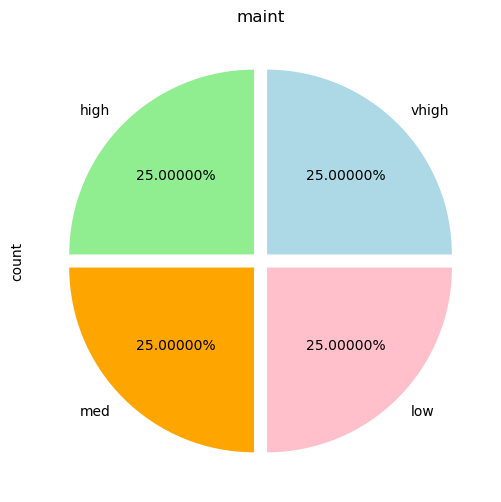

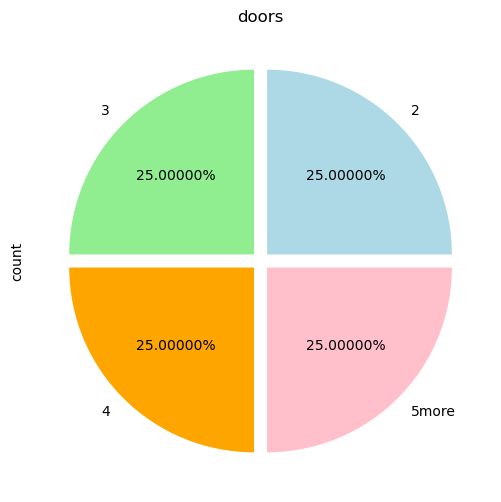

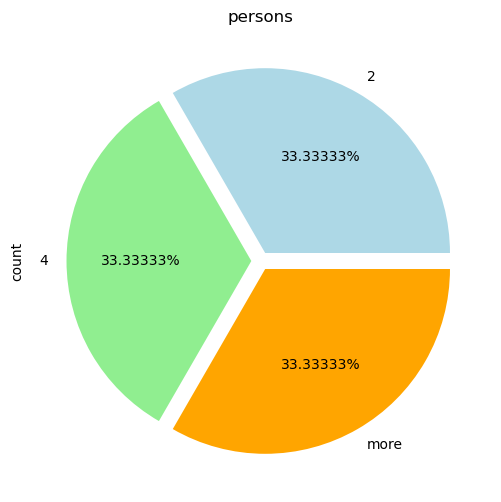

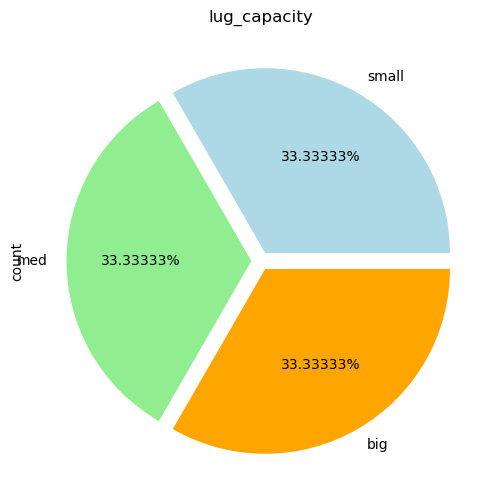

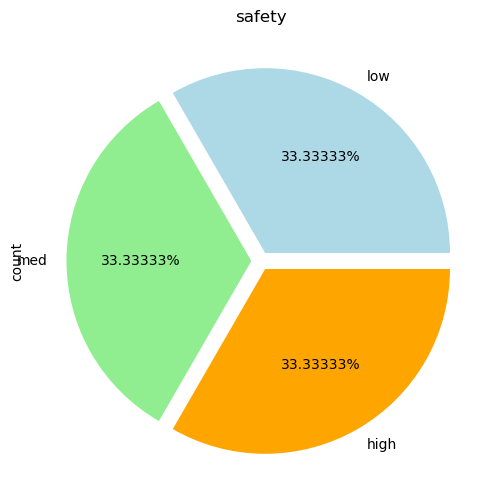

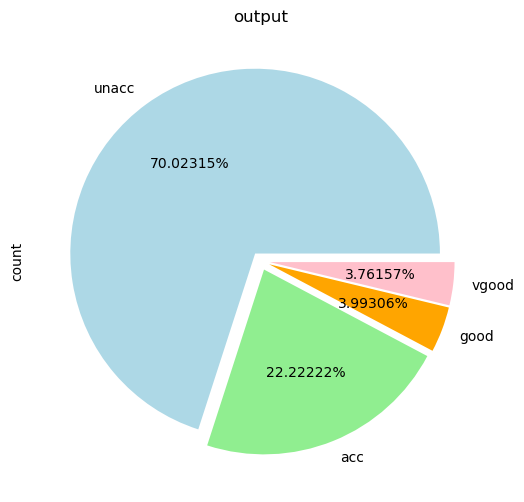

In [25]:
# data distribution
# value_counts()를 이용
colname = car_df.columns.to_list()
for col in colname:
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 8; fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size

    try:
        car_df[col].value_counts().plot(kind='pie', autopct='%0.05f%%',
                                        colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05, 0.05))
    except:
        car_df[col].value_counts().plot(kind='pie', autopct='%0.05f%%',
                                        colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05))
    plt.title(col)
    plt.show()

In [41]:
del colname[-1]

In [42]:
# data encoding

for col in colname:
    car_df[col] = car_df[col].astype('category')
    
price = car_df['price'].cat.codes.values
maint = car_df['maint'].cat.codes.values
doors = car_df['doors'].cat.codes.values
person = car_df['persons'].cat.codes.values
lug_capacity = car_df['lug_capacity'].cat.codes.values
safety = car_df['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, person, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

- categorical data -> DataFrame[category] -> numpy array -> tensor

In [43]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [45]:
# label
outputs = pd.get_dummies(car_df['output'])
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()   # 1D

print(categorical_data.shape, outputs.shape)

torch.Size([1728, 6]) torch.Size([6912])


In [47]:
categorical_column_sizes = [len(car_df[column].cat.categories) for column in colname]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1) // 2)) for col_size in categorical_column_sizes]
categorical_embedding_sizes

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]

In [55]:
total_records = 1728
test_records = int(total_records * .2) # 전체의 20% 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [56]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [57]:
# create model network

class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()  # 문법인가?
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols       # 입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size에 저장
        
        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i
            
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)
        # 신경망의 모든 계층이 순차적으로 실행되도록 모든 계층에 대한 목록(all_layers)을 nn.Sequential 클래스로 전달
        
    # 순전파인가?
    def forward(self, x_categorical):
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
            
        x = torch.cat(embeddings, 1)    # 넘파이의 concatenate와 같지만 대상이 텐서가 됨
        x = self.embedding_dropout(x)
        x = self.layers(x)

        return x

In [58]:
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [59]:
# model parameter
loss_function = nn.CrossEntropyLoss()   # 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)      # 옵티마이저: 최적화 하려고 사용하는 거. 활성함수 비슷?, lr: 학습률

In [62]:
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')

In [63]:
# model learning

epochs = 500       # 학습 횟수?
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)   # 반복할 때마다 오차를 저장
    
    if i%25 == 1:
        print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")
        
    optimizer.zero_grad()
    single_loss.backward()
    # 가중치를 업데이트하기 위해 손실함수의 backward() 메서드를 호출, 오차역전파!!!
    optimizer.step()    # 옵티마이저의 step() 메서드를 이용하여 기울기 업데이트

print(f"epoch: {i:3} loss: {single_loss.item():10.10f}")     # 오차가 25 epoch 마다 출력

epoch:   1 loss: 1.66617930
epoch:  26 loss: 1.46374214
epoch:  51 loss: 1.34734344
epoch:  76 loss: 1.24007332
epoch: 101 loss: 1.10586679
epoch: 126 loss: 0.93804008
epoch: 151 loss: 0.83247459
epoch: 176 loss: 0.75350720
epoch: 201 loss: 0.69979209
epoch: 226 loss: 0.66864192
epoch: 251 loss: 0.63842785
epoch: 276 loss: 0.61133248
epoch: 301 loss: 0.62030566
epoch: 326 loss: 0.60396039
epoch: 351 loss: 0.60425603
epoch: 376 loss: 0.58825749
epoch: 401 loss: 0.58621389
epoch: 426 loss: 0.57997859
epoch: 451 loss: 0.57883936
epoch: 476 loss: 0.57509792
epoch: 500 loss: 0.5749462843


In [64]:
# test
test_outputs = test_outputs.to(device=device, dtype=torch.int64)

with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f"Loss: {loss:.8f}")

Loss: 0.56491113


In [65]:
print(y_val[:5])

tensor([[ 5.4218,  4.0889, -8.3098, -7.7789],
        [ 2.1395,  1.2164, -2.8839, -2.8291],
        [ 3.3240,  2.4301, -4.1427, -4.0805],
        [ 2.0405,  1.1389, -2.4779, -2.5136],
        [ 4.4644,  3.1153, -6.3794, -7.2567]])


In [66]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])    # 가장 큰 값을 가지는 인덱스 추출

tensor([0, 0, 0, 0, 0])


In [67]:
# 정홛도 확인
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [71]:
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(f'accuracy score: {accuracy_score(test_outputs, y_val)*100:.2f} %')

[[258   1]
 [ 85   1]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.50      0.01      0.02        86

    accuracy                           0.75       345
   macro avg       0.63      0.50      0.44       345
weighted avg       0.69      0.75      0.65       345

accuracy score: 75.07 %
